# 1. Establaciendo conexión con el Sentinel 2

In [28]:
from sentinelhub import SHConfig
from dotenv import load_dotenv, find_dotenv
import os
load_dotenv(find_dotenv(filename=".env"), override=True)
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from datetime import datetime, timedelta 
import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

CLIENT_ID = os.environ.get("CLIENT_ID")
CLIENT_SECRET = os.environ.get("CLIENT_SECRET")

config = SHConfig(  
    instance_id='',
    sh_client_id=CLIENT_ID,
    sh_client_secret=CLIENT_SECRET,
    sh_base_url='https://services.sentinel-hub.com',
    sh_auth_base_url='https://services.sentinel-hub.com',
   
)


c:\Users\josue\uvg\Semestre 8\data science\Lake-Cyanobacteria-Sentinel2-Analysis\ds-env\Lib\site-packages\sentinelhub\config.py:54: SHDeprecationWarning: The parameter `sh_auth_base_url` of `SHConfig` has been replaced with `sh_token_url`. Please update your configuration, for now the parameters were automatically adjusted to `sh_token_url = sh_auth_base_url + '/oauth/token'`.
  warnings.warn(


## 2. Descargando los .tiff de cada uno de los lagos

Puntos de interes

In [11]:
lagos = {
    "lago_atitlan" : {
        "west": -91.326256,
        "east": -91.07151,
        "south": 14.5948,
        "north": 14.750979
    },
    "lago_amatitlan": {
        "west": -90.638065,
        "east": -90.512924,
        "south": 14.412347,
        "north": 14.493799
    }
}

Eval script con todas las bandas

In [13]:

evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""

Definiendo BBOX's

In [30]:
resolution = 60 # max 200

#Amatitlan
betsiboka_coords_wgs84_amatitlan = (
    lagos["lago_amatitlan"]["west"], 
    lagos["lago_amatitlan"]["south"], 
    lagos["lago_amatitlan"]["east"], 
    lagos["lago_amatitlan"]["north"]
) 

betsiboka_bbox_amatitlan = BBox(bbox=betsiboka_coords_wgs84_amatitlan, crs=CRS.WGS84)
betsiboka_size_amatitlan = bbox_to_dimensions(betsiboka_bbox_amatitlan, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {betsiboka_size_amatitlan} pixels")


# Atitlan
betsiboka_coords_wgs84_atitlan = (
    lagos["lago_atitlan"]["west"],
    lagos["lago_atitlan"]["south"],
    lagos["lago_atitlan"]["east"],
    lagos["lago_atitlan"]["north"]
)

betsiboka_bbox_atitlan = BBox(bbox=betsiboka_coords_wgs84_atitlan, crs=CRS.WGS84)
betsiboka_size_atitlan = bbox_to_dimensions(betsiboka_bbox_atitlan, resolution=resolution)

# Esto serviera para iterar el request mas adelante :)
box_and_sizes = {
    "Amatitlan": {
        "bbox": betsiboka_bbox_amatitlan,
        "size": betsiboka_size_amatitlan
    },
    "atitlan": {
        "bbox": betsiboka_bbox_atitlan,
        "size": betsiboka_size_atitlan
    }
}

print(f"Image shape at {resolution} m resolution: {betsiboka_size_atitlan} pixels")

Image shape at 60 m resolution: (223, 153) pixels
Image shape at 60 m resolution: (455, 292) pixels


Request test con lago amatitlan

In [20]:
# Request test para el lago de amatitlan
request_test_amatitlan_all_bands = SentinelHubRequest(
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-01", "2020-06-30"), # Intervalo de ejemplo
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=betsiboka_bbox_amatitlan,
    size=betsiboka_size_amatitlan,
    config=config,
)

all_bands_response_amatitlan = request_test_amatitlan_all_bands.get_data()

# Request test para el lago de atitlan

request_test_atitlan_all_bands = SentinelHubRequest(
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-01", "2020-06-30"), # Intervalo de ejemplo
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=betsiboka_bbox_atitlan,
    size=betsiboka_size_atitlan,
    config=config,
)

all_bands_response_atitlan = request_test_atitlan_all_bands.get_data()



Bandas RGB ejemplo

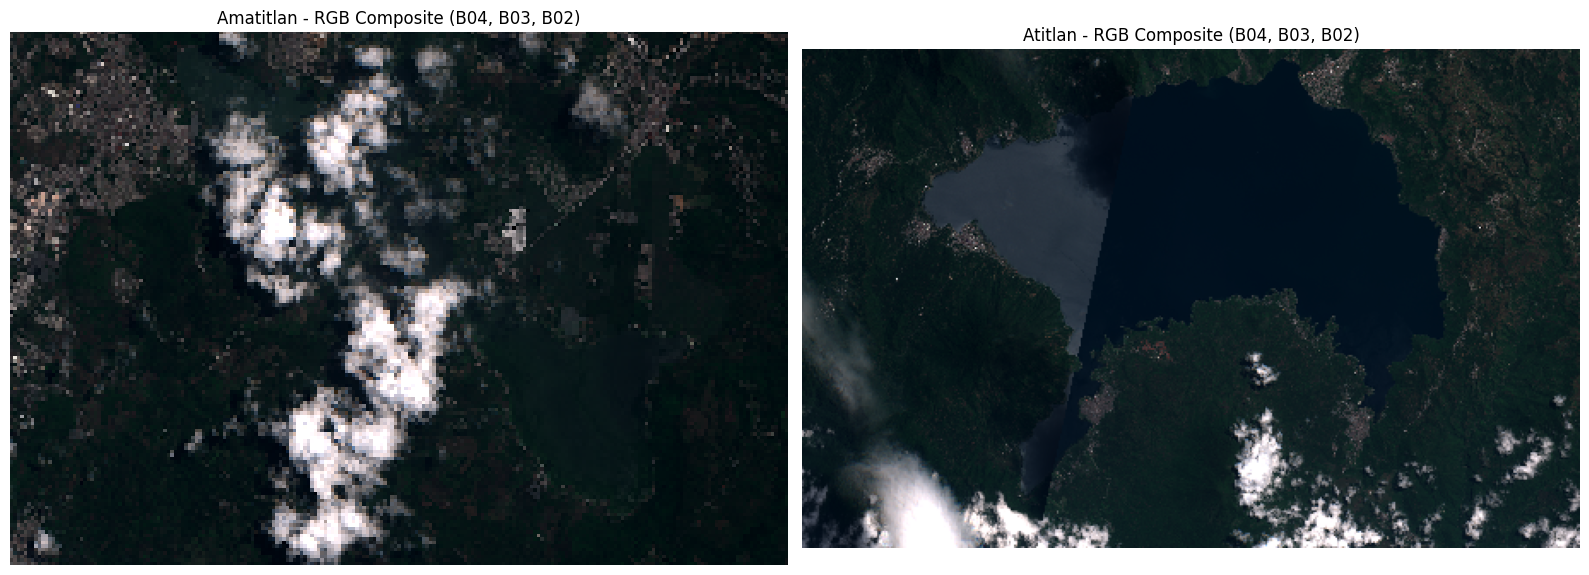

In [26]:
rgb_amatitlan = all_bands_response_amatitlan[0][:, :, [3, 2, 1]].astype(float)
rgb_min_ama = np.percentile(rgb_amatitlan, 1)
rgb_max_ama = np.percentile(rgb_amatitlan, 99)
rgb_amatitlan = np.clip((rgb_amatitlan - rgb_min_ama) / (rgb_max_ama - rgb_min_ama), 0, 1)

rgb_atitlan = all_bands_response_atitlan[0][:, :, [3, 2, 1]].astype(float)
rgb_min_ati = np.percentile(rgb_atitlan, 1)
rgb_max_ati = np.percentile(rgb_atitlan, 99)
rgb_atitlan = np.clip((rgb_atitlan - rgb_min_ati) / (rgb_max_ati - rgb_min_ati), 0, 1)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(rgb_amatitlan)
axes[0].set_title('Amatitlan - RGB Composite (B04, B03, B02)')
axes[0].axis('off')

axes[1].imshow(rgb_atitlan)
axes[1].set_title('Atitlan - RGB Composite (B04, B03, B02)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# 3. Seleccionando intervalo de tiempo 
Ahora con los intervalos de tiempo, se descaragaran los .tiff para cada lago

In [27]:
start = datetime.datetime(2024, 6, 1)
end = datetime.datetime(2025, 6, 30)
n_chunks = 13
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

print("Monthly time windows:\n")
for slot in slots:
    print(slot)

Monthly time windows:

('2024-06-01', '2024-07-01')
('2024-07-01', '2024-07-31')
('2024-07-31', '2024-08-30')
('2024-08-30', '2024-09-30')
('2024-09-30', '2024-10-30')
('2024-10-30', '2024-11-29')
('2024-11-29', '2024-12-30')
('2024-12-30', '2025-01-29')
('2025-01-29', '2025-02-28')
('2025-02-28', '2025-03-31')
('2025-03-31', '2025-04-30')
('2025-04-30', '2025-05-30')


In [ ]:
for lake in box_and_sizes:
    request_all_bands = SentinelHubRequest(
    data_folder="out",
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-01", "2020-06-30"),
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=box_and_sizes[lake]["bbox"],
    size=box_and_sizes[lake]["size"],
    config=config,
)

In [31]:
from datetime import datetime, timedelta

start = datetime(2024, 6, 1)
end = datetime(2025, 6, 30)
n_chunks = 13
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date() for i in range(n_chunks)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

print("Daily requests in each monthly window:\n")
for slot in slots:
    print(f"Interval: {slot[0]} to {slot[1]}")
    current_day = slot[0]
    while current_day < slot[1]:
        next_day = current_day + timedelta(days=1)
        for lake in box_and_sizes:
            request_all_bands = SentinelHubRequest(
                data_folder="out",
                evalscript=evalscript_all_bands,
                input_data=[
                    SentinelHubRequest.input_data(
                        data_collection=DataCollection.SENTINEL2_L1C,
                        time_interval=(current_day.isoformat(), next_day.isoformat()),
                        mosaicking_order=MosaickingOrder.LEAST_CC,
                    )
                ],
                responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
                bbox=box_and_sizes[lake]["bbox"],
                size=box_and_sizes[lake]["size"],
                config=config,
            )
            # Para descargar la imagen:
            all_bands_img = request_all_bands.get_data(save_data=True)
            # Puedes guardar la imagen con rasterio o como prefieras
        current_day = next_day

Daily requests in each monthly window:

Interval: 2024-06-01 to 2024-07-01
Interval: 2024-07-01 to 2024-07-31
Interval: 2024-07-31 to 2024-08-30
Interval: 2024-08-30 to 2024-09-30
Interval: 2024-09-30 to 2024-10-30
Interval: 2024-10-30 to 2024-11-29
Interval: 2024-11-29 to 2024-12-30
Interval: 2024-12-30 to 2025-01-29
Interval: 2025-01-29 to 2025-02-28
Interval: 2025-02-28 to 2025-03-31
Interval: 2025-03-31 to 2025-04-30
Interval: 2025-04-30 to 2025-05-30
